The dataset contains 5.000 CVs represented by
100 features plus a label column.

Task 1:
Build an ML model which predicts if a CV is good enough for faster processing (label = 1). Think about the following steps:
1. EDA & Visualisations
2. Dimensionality Reduction & Feature Selection
3. Validation, Loss Functions & Model Selection

In [346]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD 

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, recall_score, f1_score, precision_score

from sklearn.externals import joblib

%matplotlib inline

np.set_printoptions(precision=2)
seed = 123

A few functions:

In [ ]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

# borrowd from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Quick look at the data

In [62]:
data = pd.read_csv('cv_data.csv', )

data.shape
data.head()
data.tail()

(5000, 102)

,Unnamed: 0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,label
0,0,-0.618178,1.129168,1.010128,1.192835,0.768249,0.209120,2.166218,1.441607,-1.446846,...,1.615842,-0.236353,0.623811,0.122304,0.287379,0.768099,0.044018,0.825693,1.248335,0
1,1,0.700247,-1.034293,0.080183,0.316909,-0.846974,-0.435558,-0.345593,2.074897,-2.059102,...,0.456424,0.638302,-0.580138,0.292994,-0.436528,-0.894869,0.159073,0.063542,-1.022165,0
2,2,1.982168,0.815666,-0.025709,1.496764,0.108984,0.364357,-1.596440,0.814197,0.201527,...,2.251304,0.028086,-0.037892,-0.139871,-0.039105,-1.811305,0.225458,-0.236922,0.279700,0
3,3,-0.017635,-2.419292,0.487583,-1.398785,1.094113,0.207232,0.672458,0.095825,-1.037978,...,0.325796,-0.186635,-1.781327,-0.310428,-0.642216,1.258810,0.070900,0.203778,0.954731,0
4,4,-0.379393,1.407063,0.244219,-0.627093,-0.315542,0.155570,-0.843663,1.399437,-1.045215,...,0.488680,-0.328314,0.856943,-0.505300,-2.765062,0.648504,1.149144,0.960054,-1.303009,1


,Unnamed: 0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,label
4995,4995,-0.477590,1.796630,-0.437729,0.893326,-0.192605,-0.371277,0.536883,0.370106,-0.647853,...,0.407932,1.263048,0.661637,-0.828178,-2.208736,-0.719009,-0.614886,0.993486,-0.263729,0
4996,4996,-0.372980,-0.733785,-0.717620,0.354833,1.946138,-0.974280,-0.187164,-0.839683,-1.543228,...,-0.024598,0.546367,-0.366834,-1.307490,-0.712295,-1.241734,-0.325588,-1.042630,0.451625,0
4997,4997,2.066052,-0.978687,0.242690,-0.265012,1.889751,0.281479,-2.024112,0.303831,-1.631961,...,1.333740,-0.476233,-1.162193,-1.357717,0.358660,0.014318,-0.485745,0.126941,-0.203173,0
4998,4998,0.770699,-2.370424,0.387053,-1.137417,-0.494664,0.577999,-0.179809,0.104150,1.155251,...,-1.389146,0.283775,0.603991,-0.246014,1.837086,0.451190,0.102597,-0.789032,-0.129791,0
4999,4999,0.364842,-0.378448,-1.447703,2.288959,-0.679012,-1.692708,0.261159,-0.057784,1.374733,...,-1.282237,-0.260680,-0.307893,-0.586093,-1.774156,-1.095873,0.362555,0.036051,1.429334,0


Shame that features are anonymous.

<add>

In [63]:
# let's drop the redundant column
data.drop(['Unnamed: 0'], axis=1, inplace=True)
# and check the distributions
data.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,label
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.005192,-0.004869,-0.017254,0.765347,0.030322,0.028968,0.000685,0.004324,0.023287,-0.024759,...,0.018854,-0.014181,0.005552,0.006580,-0.019566,-0.006327,-0.010530,-0.006926,0.003280,0.204600
std,1.002413,1.011197,0.997264,1.550600,0.988901,0.964846,0.999098,0.991979,1.015193,0.993635,...,1.470865,0.997660,0.998537,0.987434,1.015106,1.002770,1.007099,1.002265,1.008799,0.403449
min,-3.366054,-3.601696,-3.932327,-6.607799,-3.479480,-4.105513,-4.181590,-3.325110,-3.457341,-3.383411,...,-4.349274,-3.546245,-3.348487,-3.478873,-3.682783,-4.037248,-3.829066,-3.753101,-3.569487,0.000000
25%,-0.680917,-0.708825,-0.698633,-0.161394,-0.628388,-0.611935,-0.687047,-0.680277,-0.673552,-0.699473,...,-1.082261,-0.675837,-0.661008,-0.653918,-0.704699,-0.695756,-0.697693,-0.688663,-0.667131,0.000000
50%,-0.006642,-0.010187,0.006988,0.822043,0.018704,0.021682,0.007988,0.011465,0.031568,-0.016413,...,-0.057890,-0.012857,-0.005716,0.001458,-0.014265,-0.012765,-0.026506,-0.000523,-0.000941,0.000000
75%,0.693529,0.700252,0.648129,1.793108,0.673497,0.677378,0.674216,0.661604,0.698430,0.644711,...,1.089448,0.644647,0.664868,0.664896,0.665404,0.666440,0.666962,0.675986,0.666557,0.000000
max,3.652937,3.955115,3.466805,6.464047,3.546513,3.235450,3.838283,4.047412,3.810192,3.985219,...,5.298039,3.552676,3.437890,4.361830,3.585472,3.861640,3.630180,4.135319,3.391459,1.000000


Well, feature values are quite similar. Possibly the initial data was text or images, but this is an assumption.

In [355]:
data['label'].value_counts()

0    3977
1    1023
Name: label, dtype: int64

The data set is unbalanced, we'll fix it. But first let's remove correlated features.

<add>

In [64]:
corr_matrix = data.corr().abs()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find index of feature columns with correlation greater than 0.50
to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]
print('Features to drop', to_drop)

Features to drop ['feature_31', 'feature_72', 'feature_92']


In [65]:
# drop features
data.drop(to_drop, axis=1, inplace=True)

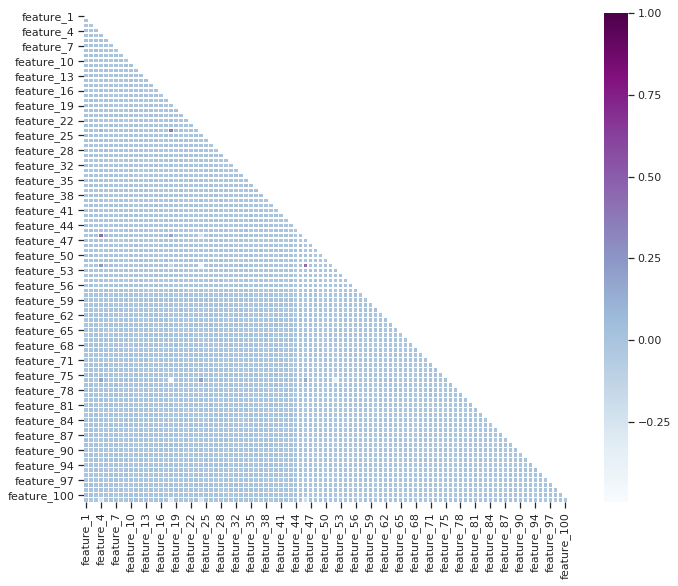

In [79]:
# Compute the correlation matrix 
corr_all = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show();

## Preparation

Even though the data point are quite similar, let's put all features in the same unit of measurement (the range between 0 and 1), it will improve the maximization of the variance for each component that our PCA needs to perform its matrix operations in the best way.

And let's check both PCA and SVD:

In [142]:
label = data['label']
features = data.drop(['label'], axis=1)

In [143]:
scaler = MinMaxScaler(feature_range=[0, 1])
features_rescaled = scaler.fit_transform(features.values)
features_rescaled

array([[0.39149166, 0.62603977, 0.66797764, ..., 0.5192327 , 0.58044501,
        0.69212166],
       [0.57932841, 0.33974691, 0.54229475, ..., 0.53465718, 0.48382858,
        0.36594477],
       [0.76196451, 0.58455373, 0.52798333, ..., 0.54355692, 0.44573924,
        0.55296889],
       ...,
       [0.7739155 , 0.34710533, 0.56425766, ..., 0.44821171, 0.49186549,
        0.48359999],
       [0.58936585, 0.16293535, 0.58376853, ..., 0.52708595, 0.37574929,
        0.49414194],
       [0.53154304, 0.42653551, 0.33579933, ..., 0.56193632, 0.48034357,
        0.71812369]])

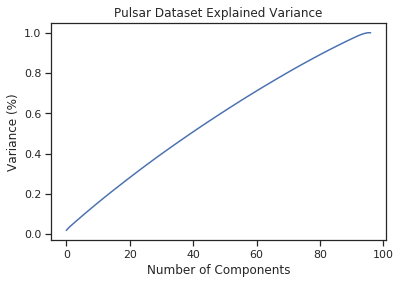

In [144]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(features_rescaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure();
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.xlabel('Number of Components');
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance');
plt.show();

In [146]:
pca = PCA(n_components=features.shape[1]-1).fit(features_rescaled)
pca.explained_variance_ratio_.sum()

0.9997091083529932

In [148]:
# Run function
pca_var_ratios = pca.explained_variance_ratio_
select_n_components(pca_var_ratios, 0.95)

89

In [149]:
svd = TruncatedSVD(n_components=89, random_state=seed).fit(features_rescaled)
var_explained = svd.explained_variance_ratio_.sum()
var_explained

0.9547720473192502

In [151]:
pca = PCA(n_components=89).fit(features_rescaled)
transformed_features = pca.transform(features_rescaled)
transformed_features.shape

(5000, 89)

In [214]:
# Train, test, validation sets
X_train, X_test, y_train, y_test = train_test_split(
    transformed_features, label, test_size=0.2, random_state=seed, stratify=label)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed)

print('Train: {}, test: {}, val: {}'.format(X_train.shape[0], X_test.shape[0], X_val.shape[0]))

Train: 3200, test: 1000, val: 800


In [225]:
## OverSampling with replacement on train set
y_train.value_counts()

0    2562
1     638
Name: label, dtype: int64

Resampled dataset shape Counter({0: 2562, 1: 2562})


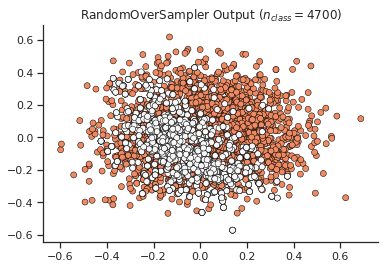

In [309]:
ros = RandomOverSampler('minority', random_state=seed)

ros.fit(X_train, y_train)

X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_train_oversampled]
plt.scatter(X_train_oversampled[:, 0], X_train_oversampled[:, 1], c=colors, linewidth=0.5, edgecolor='black');

sns.despine();
plt.title("RandomOverSampler Output ($n_{class}=4700)$");

print('Resampled dataset shape {}'.format(
    Counter(y_train_oversampled)));

Resampled dataset shape Counter({0: 638, 1: 638})


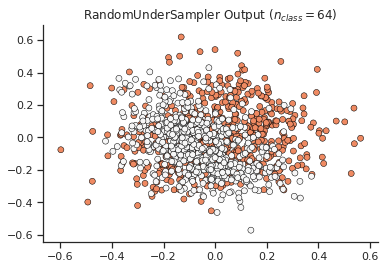

In [311]:
rus = RandomUnderSampler(random_state=seed)
rus.fit(X_train, y_train)

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_train_undersampled]
plt.scatter(X_train_undersampled[:, 0], X_train_undersampled[:, 1], c=colors, linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("RandomUnderSampler Output ($n_{class}=64)$")

print('Resampled dataset shape {}'.format(
    Counter(y_train_undersampled)));

We see that these two features can't really separate the classes.

## Modeling

### Random Forest

In [315]:
# base
random_forest = RandomForestClassifier(n_estimators=100, max_depth=20)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_forest.fit(X_train_oversampled, y_train_oversampled)
y_pred_with_oversample = random_forest.predict(X_test)


#Train the model using the training sets y_pred=clf.predict(X_test)
random_forest.fit(X_train_undersampled, y_train_undersampled)
y_pred_with_undersample = random_forest.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [319]:
target_names = ['not good enough', 'good enough']
print('Oversampled train:\n{}\n'.format(classification_report(y_test, y_pred_with_oversample, target_names=target_names)))
print('Undersampled train:\n{}'.format(classification_report(y_test, y_pred_with_undersample, target_names=target_names)))

Oversampled train:
                 precision    recall  f1-score   support

not good enough       0.80      1.00      0.89       795
    good enough       0.81      0.06      0.12       205

      micro avg       0.81      0.81      0.81      1000
      macro avg       0.81      0.53      0.50      1000
   weighted avg       0.81      0.81      0.73      1000


Undersampled train:
                 precision    recall  f1-score   support

not good enough       0.89      0.70      0.78       795
    good enough       0.37      0.68      0.48       205

      micro avg       0.69      0.69      0.69      1000
      macro avg       0.63      0.69      0.63      1000
   weighted avg       0.79      0.69      0.72      1000



Depending on the case, we want to optimize for the concrete metric, be it precision or recall.

Here, the model on oversampled data was great at finding all not goo enough CVs, thus the recall is 1.00, but simply aweful at detecting the good ones. If the priority is to filter out all possible not goo enoughs, than this model is great. But there is a big chance of filtering actual good CVs. Here comes a trade off and business priorities.

But, let's assume that we want to balance it out and minimize the number of False Negatives, predicted as not good enough CVs when in reality they are good enough. In this case we are going to work on the model that was trained on the undersampled data. Hence, optimizing for the f1-score.

Below is a nice plot of TP, TN, FP, FN:

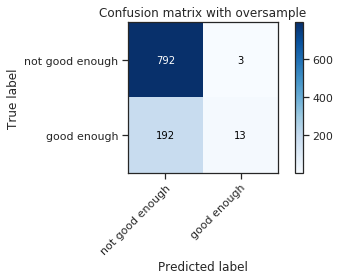

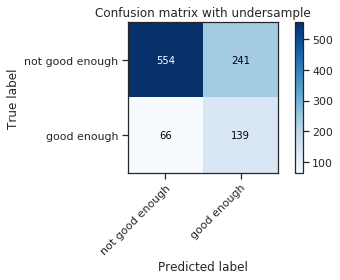

In [325]:
plot_confusion_matrix(y_test, y_pred_with_oversample, classes=target_names, title='Confusion matrix with oversample')
plot_confusion_matrix(y_test, y_pred_with_undersample, classes=target_names, title='Confusion matrix with undersample')

plt.show();

In [339]:
param_grid = {
    'min_samples_split': [10, 15, 20],
    'max_depth': [25, 30, 50]
}

scorers = {
    # in case we decide to optimize for a certain metric
    # here they are
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    
}

kf = KFold(n_splits=5)
refit_score='f1_score'

In [340]:
grid_search = GridSearchCV(
    random_forest, param_grid, scoring=scorers, refit=refit_score,
    cv=kf, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_undersampled, y_train_undersampled)

/Users/elenapetrova/venvs/jupyterlab/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_split': [10, 15, 20], 'max_depth': [25, 30, 50]},
       pre_dispatch='2*n_jobs', refit='f1_score', return_train_score=True,
       scoring={'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score), 'f1_score': make_scorer(f1_score)},
       verbose=0)

In [341]:
# make the predictions
y_pred = grid_search.predict(X_test)

print('Best params for {}'.format(refit_score))
print(grid_search.best_params_)

# confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

Best params for f1_score
{'max_depth': 30, 'min_samples_split': 10}

Confusion matrix of Random Forest optimized for f1_score on the test data:
     pred_neg  pred_pos
neg       577       218
pos        78       127


Certainly the improvement is quite unsignificant, but let's say we found our model and optimized for the metric in question:

In [344]:
random_forest_final = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split= 10)
random_forest_final.fit(X_train_undersampled, y_train_undersampled)

y_pred_on_val = random_forest_final.predict(X_val)
print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
print('Validation:\n{}'.format(classification_report(y_val, y_pred_on_val, target_names=target_names)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

     pred_neg  pred_pos
neg       577       218
pos        78       127
Validation:
                 precision    recall  f1-score   support

not good enough       0.88      0.70      0.78       620
    good enough       0.39      0.68      0.50       180

      micro avg       0.69      0.69      0.69       800
      macro avg       0.64      0.69      0.64       800
   weighted avg       0.77      0.69      0.72       800



In [347]:
joblib.dump(random_forest_final, 'random_forest.pkl')

['random_forest.pkl']

### Next steps

- The success of the project will depend on the business priority (which metric we should optimize for, recall or precision) and be tested out on the validation set, not touched until the end stage.
- Given more time and clearer understanding of data in hands, I would do extensive EDA and Feature Engineering. Here, the features are anonymous, which makes it if not sometimes impossible but hard. I would also do my best to understand the business logic, before adding more features and feature engineering steps.
- I would also try out other algorithms, XGboost (maybe Light GBM too) and NN. RandomForest is simply the go-to model to try out.
- In terms of testing, this would include testing for the data tranformation and feature engineering steps if present. In case of API, it should be tested too.

Thank you for reading!

Elena